In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint as sp_randint
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV 
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
def calculate_missing_values(df):
    missing_values_count = df.isnull().sum()
    missing_values_pers = 100 * missing_values_count / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([missing_values_count, missing_values_pers], axis=1)
        
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    
    return mis_val_table_ren_columns

In [3]:
nrows = 200000
CourtCase = pd.read_csv("CourtCase.csv")
CourtCase_test = pd.read_csv("CourtCase_test.csv")
CourtCase = CourtCase.sample(frac=1)

CourtCaseParty = pd.read_csv("CourtCaseParty.csv")
CourtCaseParty["IsNPPA"] = CourtCaseParty.PartyID.apply(lambda x: 1 if x == -2 else 0)

ccp_aggregations = {}
ccp_aggregations["CourtCasePartyID"] = {"ccp_count" : "count"}
ccp_aggregations["IsNPPA"] = {"is_nppa_present" : "max"}

CourtCaseParty = CourtCaseParty.groupby("CourtCaseID").agg({**ccp_aggregations})
CourtCaseParty.columns = CourtCaseParty.columns.droplevel(level=0)
CourtCase = pd.merge(CourtCase, CourtCaseParty, how='left', left_on="CourtCaseID", right_index=True)
CourtCase_test = pd.merge(CourtCase_test, CourtCaseParty, how='left', left_on="CourtCaseID", right_index=True)

CourtCaseSchedule = pd.read_csv("CourtCaseSchedule.csv")

ccsh_aggregations = {"HearingDate" : {"min_hearingdate" : "min"}}
CourtCaseSchedule = CourtCaseSchedule.groupby("CourtCaseID").agg({**ccsh_aggregations})
CourtCaseSchedule.columns = CourtCaseSchedule.columns.droplevel(level=0)
CourtCase = pd.merge(CourtCase, CourtCaseSchedule, how='left', left_on="CourtCaseID", right_index=True)
CourtCase_test = pd.merge(CourtCase_test, CourtCaseSchedule, how='left', left_on="CourtCaseID", right_index=True)

CourtCaseCrimes = pd.read_csv("CourtCaseCrimes.csv")
CourtCaseCrimes = CourtCaseCrimes.groupby("CourtCaseID").count()
CourtCase = pd.merge(CourtCase, CourtCaseCrimes, how='left', left_on="CourtCaseID", right_index=True)
CourtCase_test = pd.merge(CourtCase_test, CourtCaseCrimes, how='left', left_on="CourtCaseID", right_index=True)

CourtCasePartyLegalRepresentative = pd.read_csv("CourtCasePartyLegalRepresentative.csv")
CourtCase = pd.merge(CourtCase, CourtCasePartyLegalRepresentative, how='left', left_on="CourtCaseID", right_on="CourtCaseID")
CourtCase_test = pd.merge(CourtCase_test, CourtCasePartyLegalRepresentative, how='left', left_on="CourtCaseID", right_on="CourtCaseID")

# CourtCaseAddmisibility = pd.read_csv("CourtCaseAddmisibility.csv")
# ccai_aggregations = {"AdmissibilityItemID" : {"cnt_admitem" : "count"}}
# CourtCaseAddmisibility = CourtCaseAddmisibility.groupby("CourtCaseID").agg({**ccai_aggregations})
# CourtCaseAddmisibility.columns = CourtCaseAddmisibility.columns.droplevel(level=0)
# CourtCase = pd.merge(CourtCase, CourtCaseAddmisibility, how='left', left_on="CourtCaseID", right_index=True)
# CourtCase_test = pd.merge(CourtCase_test, CourtCaseAddmisibility, how='left', left_on="CourtCaseID", right_index=True)

# CourtCaseIssues = pd.read_csv("CourtCaseIssues.csv")
# ccissues_aggregations = {"CourtCaseIssuesToBeAnalysedID" : {"cnt_issues" : "count"}}
# CourtCaseIssues = CourtCaseIssues.groupby("CourtCaseID").agg({**ccissues_aggregations})
# CourtCaseIssues.columns = CourtCaseIssues.columns.droplevel(level=0)
# CourtCase = pd.merge(CourtCase, CourtCaseIssues, how='left', left_on="CourtCaseID", right_index=True)
# CourtCase_test = pd.merge(CourtCase_test, CourtCaseIssues, how='left', left_on="CourtCaseID", right_index=True)

CourtCaseDocument = pd.read_csv("CourtCaseDocument.csv")
CourtCaseDocument = pd.get_dummies(CourtCaseDocument, columns=["DocumentTypeID"])
cc_doc_dum_agg = {}
dum_columns = [x for x in CourtCaseDocument.columns if x.startswith("DocumentTypeID")]
for col in dum_columns:
    cc_doc_dum_agg[col] = {col:"sum"}
ccdoc_aggregations = {"Size" : {"total_size" : "sum", "avg_size" : "mean"}}
CourtCaseDocument = CourtCaseDocument.groupby("CourtCaseID").agg({**ccdoc_aggregations, **cc_doc_dum_agg})
CourtCaseDocument.columns = CourtCaseDocument.columns.droplevel(level=0)
CourtCase = pd.merge(CourtCase, CourtCaseDocument, how='left', left_on="CourtCaseID", right_index=True)
CourtCase_test = pd.merge(CourtCase_test, CourtCaseDocument, how='left', left_on="CourtCaseID", right_index=True)



[CourtCase[x].fillna(0, inplace=True) for x in CourtCase.columns if x.startswith("ArticleID")];
CourtCase.CountOfLegalRepresentative.fillna(0, inplace=True)
CourtCase.ccp_count.fillna(0, inplace=True)
# CourtCase.cnt_admitem.fillna(0, inplace=True)
# CourtCase.cnt_issues.fillna(0, inplace=True)
CourtCase.is_nppa_present.fillna(0, inplace=True)

[CourtCase_test[x].fillna(0, inplace=True) for x in CourtCase_test.columns if x.startswith("ArticleID")];
CourtCase_test.CountOfLegalRepresentative.fillna(0, inplace=True)
CourtCase_test.ccp_count.fillna(0, inplace=True)
# CourtCase_test.cnt_admitem.fillna(0, inplace=True)
# CourtCase_test.cnt_issues.fillna(0, inplace=True)
CourtCase_test.is_nppa_present.fillna(0, inplace=True)

c:\python36-64\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
c:\python36-64\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print(CourtCase_test.shape)
print(CourtCase.shape)

(2359, 114)
(15832, 114)


In [5]:
CourtCase["HasRecieptDocument"] = CourtCase.ReceiptDocumentID.fillna(0).apply(lambda x: 1 if x > 0 else 0)
CourtCase["HasProsecutionCase"] = CourtCase.ProsecutionCaseID.fillna(0).apply(lambda x: 1 if x > 0 else 0)
# CourtCase["IsAppealedcase"] = CourtCase.AppealedCourtCaseID.fillna(0).apply(lambda x: 1 if x > 0 else 0)
CourtCase["ColorID"] = CourtCase.ColorID.fillna(-1)
CourtCase["InstanceLevelID"] = CourtCase.InstanceLevelID.fillna(-1)
CourtCase["SubCategoryID"] = CourtCase.SubCategoryID.fillna(-1)
CourtCase["CasePriorityID"] = CourtCase.CasePriorityID.fillna(-1)
CourtCase["IsDetentionCase"] = CourtCase.IsDetentionCase.fillna(0)
CourtCase["IsPublicCase"] = CourtCase.IsPublicCase.fillna(0)
CourtCase["CommittedByMinor"] = CourtCase.CommittedByMinor.fillna(0)
CourtCase["GenderBasedViolence"] = CourtCase.GenderBasedViolence.fillna(0)
CourtCase["InitiatedFromAbunzi"] = CourtCase.InitiatedFromAbunzi.fillna(0)
CourtCase["SolvedFromAbunzi"] = CourtCase.SolvedFromAbunzi.fillna(0)
CourtCase["HasDetails"] = CourtCase.HasDetails.fillna(0)
CourtCase["IsExempted"] = CourtCase.IsExempted.fillna(0)
CourtCase["AttachedDate"] = CourtCase.AttachedDate.fillna(0)
CourtCase.drop(columns=["HasPassedCaseNumberAllocated", "CaseCode", "MinorVersion", "MajorVersion", "CourtID", "CourtCaseID"
                   , "ReceiptDocumentID",  "ProsecutionCaseID", "WFActionID"
                   , "NotRegisteredCaseCode", "WFStateID", "UpdatedUserID", "OwnerUserID", "PublicOwnerUserId", 'CreatedUserID'
                   ,'AppealedCourtCaseID', "CountOfJudgmentPages"
                  ], inplace=True)

CourtCase_test["HasRecieptDocument"] = CourtCase_test.ReceiptDocumentID.fillna(0).apply(lambda x: 1 if x > 0 else 0)
CourtCase_test["HasProsecutionCase"] = CourtCase_test.ProsecutionCaseID.fillna(0).apply(lambda x: 1 if x > 0 else 0)
# CourtCase_test["IsAppealedcase"] = CourtCase_test.AppealedCourtCaseID.fillna(0).apply(lambda x: 1 if x > 0 else 0)
CourtCase_test["ColorID"] = CourtCase_test.ColorID.fillna(-1)
CourtCase_test["InstanceLevelID"] = CourtCase_test.InstanceLevelID.fillna(-1)
CourtCase_test["SubCategoryID"] = CourtCase_test.SubCategoryID.fillna(-1)
CourtCase_test["CasePriorityID"] = CourtCase_test.CasePriorityID.fillna(-1)
CourtCase_test["IsDetentionCase"] = CourtCase_test.IsDetentionCase.fillna(0)
CourtCase_test["IsPublicCase"] = CourtCase_test.IsPublicCase.fillna(0)
CourtCase_test["CommittedByMinor"] = CourtCase_test.CommittedByMinor.fillna(0)
CourtCase_test["GenderBasedViolence"] = CourtCase_test.GenderBasedViolence.fillna(0)
CourtCase_test["InitiatedFromAbunzi"] = CourtCase_test.InitiatedFromAbunzi.fillna(0)
CourtCase_test["SolvedFromAbunzi"] = CourtCase_test.SolvedFromAbunzi.fillna(0)
CourtCase_test["HasDetails"] = CourtCase_test.HasDetails.fillna(0)
CourtCase_test["IsExempted"] = CourtCase_test.IsExempted.fillna(0)
CourtCase_test["AttachedDate"] = CourtCase_test.AttachedDate.fillna(0)
CourtCase_test.drop(columns=["HasPassedCaseNumberAllocated", "CaseCode", "MinorVersion", "MajorVersion", "CourtID", "CourtCaseID"
                   , "ReceiptDocumentID",  "ProsecutionCaseID", "WFActionID"
                   , "NotRegisteredCaseCode", "WFStateID", "UpdatedUserID", "OwnerUserID", "PublicOwnerUserId", 'CreatedUserID'
                   ,'AppealedCourtCaseID', "CountOfJudgmentPages"
                  ], inplace=True)

In [6]:
print(CourtCase_test.shape)
print(CourtCase.shape)

(2359, 99)
(15832, 99)


In [7]:
A = calculate_missing_values(CourtCase)
drop_col = A[A["% of Total Values"] > 90].index
CourtCase = CourtCase.drop(columns=drop_col)
CourtCase.dropna(inplace=True)
CourtCase_test = CourtCase_test.drop(columns=drop_col)
CourtCase_test.dropna(inplace=True)
print(CourtCase_test.shape)
print(CourtCase.shape)

Your selected dataframe has 99 columns.
There are 69 columns that have missing values.
(2345, 90)
(15762, 90)


In [8]:
calculate_missing_values(CourtCase)
calculate_missing_values(CourtCase_test)

Your selected dataframe has 90 columns.
There are 0 columns that have missing values.
Your selected dataframe has 90 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [9]:
X = CourtCase.drop(columns=["DecisionDuration"])
Y = CourtCase["DecisionDuration"]

# X_test = X[:100]
# Y_test = Y[:100]
# X = X[100:]
# Y = Y[100:]
X_test = CourtCase_test.drop(columns=["DecisionDuration"])
Y_test = CourtCase_test["DecisionDuration"]
print(X.shape, Y.shape)
print(X_test.shape, Y_test.shape)

(15762, 89) (15762,)
(2345, 89) (2345,)


In [10]:
Y_test.head()

0    144
1    109
2     81
3     56
4     59
Name: DecisionDuration, dtype: int64

In [180]:
# Number of trees in random forest
n_estimators = [50, 100, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 3, 5, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 64]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# random_grid = {"max_depth": [3, None],
#               "max_features": sp_randint(1, 11),
#               "min_samples_split": sp_randint(2, 11),
#               "min_samples_leaf": sp_randint(1, 11),
#               "bootstrap": [True, False]
#               }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=100, random_state=42, scoring='r2')
# Fit the random search model
rf_random.fit(X, Y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=3, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=3, bootstrap=True, score=0.37312338373259646, total=   1.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=3, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=3, bootstrap=True, score=0.38260857533645987, total=   1.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=3, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=3, bootstrap=True, score=0.3771377800737

KeyboardInterrupt: 

In [14]:
rf_random.best_score_

0.6747733428842665

In [11]:
rf_params = {'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}
# rf_params = rf_random.best_params_
rf_params

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [12]:
rf = RandomForestRegressor(**rf_params)
# np.mean(cross_val_score(rf, X, Y, scoring='r2', cv=5, verbose=5))

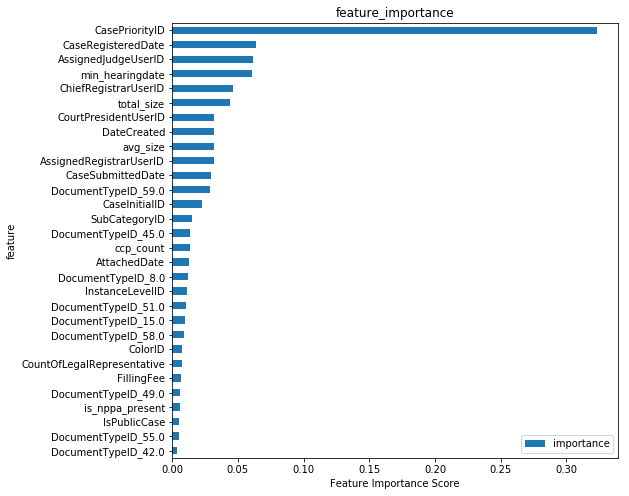

In [13]:
rf.fit(X, Y)
rf.feature_importances_

feat_imp = pd.DataFrame({'importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:30]
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title="feature_importance", figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

In [14]:
rf.fit(X, Y)
y_pred = rf.predict(X_test)
r2_score(Y_test, y_pred)

0.6945073979930119

In [15]:
boost = GradientBoostingRegressor()
# np.mean(cross_val_score(boost, X, Y, scoring='r2', cv=5, verbose=5))
# boost.fit(X, Y)
# y_pred = boost.predict(X)
# r2_score(Y, y_pred)

In [76]:
# Number of trees in random forest
n_estimators = [100, 200]
learning_rate = [0.01, 0.05, 0.1]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 20]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 40, 60]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_boost = {'n_estimators': n_estimators,
               'max_features': max_features,
                'learning_rate' : learning_rate,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }

# random_grid = {"max_depth": [3, None],
#               "max_features": sp_randint(1, 11),
#               "min_samples_split": sp_randint(2, 11),
#               "min_samples_leaf": sp_randint(1, 11),
#               "bootstrap": [True, False]
#               }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
boost = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
boost_random = RandomizedSearchCV(estimator = boost, param_distributions = random_boost, n_iter = 20, cv = 5, verbose=100, random_state=42, scoring='r2', n_jobs=1)
# Fit the random search model
boost_random.fit(X, Y)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=10, learning_rate=0.05 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=10, learning_rate=0.05, score=0.69225534358071, total=   3.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=10, learning_rate=0.05 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=10, learning_rate=0.05, score=0.6621898808366429, total=   3.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=10, learning_rate=0.05 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=10, learning_

[CV]  n_estimators=200, min_samples_split=40, min_samples_leaf=4, max_features=sqrt, max_depth=20, learning_rate=0.05, score=0.6886038651823163, total=  12.3s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  6.0min remaining:    0.0s
[CV] n_estimators=200, min_samples_split=40, min_samples_leaf=4, max_features=sqrt, max_depth=20, learning_rate=0.05 
[CV]  n_estimators=200, min_samples_split=40, min_samples_leaf=4, max_features=sqrt, max_depth=20, learning_rate=0.05, score=0.7115788482738079, total=  10.7s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  6.2min remaining:    0.0s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, learning_rate=0.01 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, learning_rate=0.01, score=0.6363241862505616, total=   8.8s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  6.4min remaining:    0.0s
[CV] n_estimators=200, min_samples_split=10, mi

[CV]  n_estimators=100, min_samples_split=20, min_samples_leaf=4, max_features=auto, max_depth=20, learning_rate=0.05, score=0.6796763729353559, total= 1.1min
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed: 31.3min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=20, min_samples_leaf=4, max_features=auto, max_depth=20, learning_rate=0.05 
[CV]  n_estimators=100, min_samples_split=20, min_samples_leaf=4, max_features=auto, max_depth=20, learning_rate=0.05, score=0.6448972436537264, total=  59.6s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 32.3min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=20, min_samples_leaf=4, max_features=auto, max_depth=20, learning_rate=0.05 
[CV]  n_estimators=100, min_samples_split=20, min_samples_leaf=4, max_features=auto, max_depth=20, learning_rate=0.05, score=0.6696699559826933, total= 1.1min
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed: 33.4min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=20, mi

[CV]  n_estimators=100, min_samples_split=60, min_samples_leaf=1, max_features=sqrt, max_depth=20, learning_rate=0.05, score=0.7278400808399552, total=   7.4s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed: 42.5min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=60, min_samples_leaf=1, max_features=sqrt, max_depth=20, learning_rate=0.05 
[CV]  n_estimators=100, min_samples_split=60, min_samples_leaf=1, max_features=sqrt, max_depth=20, learning_rate=0.05, score=0.6968676743107083, total=   7.8s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 42.7min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=60, min_samples_leaf=1, max_features=sqrt, max_depth=20, learning_rate=0.05 
[CV]  n_estimators=100, min_samples_split=60, min_samples_leaf=1, max_features=sqrt, max_depth=20, learning_rate=0.05, score=0.6409964566005308, total=   7.3s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed: 42.8min remaining:    0.0s
[CV] n_estimators=100, min_samples_split=60, mi

[CV]  n_estimators=200, min_samples_split=20, min_samples_leaf=2, max_features=auto, max_depth=10, learning_rate=0.05, score=0.7056332018003252, total=  44.0s
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed: 58.0min remaining:    0.0s
[CV] n_estimators=200, min_samples_split=40, min_samples_leaf=4, max_features=sqrt, max_depth=20, learning_rate=0.01 
[CV]  n_estimators=200, min_samples_split=40, min_samples_leaf=4, max_features=sqrt, max_depth=20, learning_rate=0.01, score=0.675076581124683, total=  16.5s
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 58.2min remaining:    0.0s
[CV] n_estimators=200, min_samples_split=40, min_samples_leaf=4, max_features=sqrt, max_depth=20, learning_rate=0.01 
[CV]  n_estimators=200, min_samples_split=40, min_samples_leaf=4, max_features=sqrt, max_depth=20, learning_rate=0.01, score=0.6431611814536435, total=  15.6s
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed: 58.5min remaining:    0.0s
[CV] n_estimators=200, min_samples_split=40, min

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'n_estimators': [100, 200], 'max_features': ['auto', 'sqrt'], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 20], 'min_samples_split': [2, 5, 10, 20, 40, 60], 'min_samples_leaf': [1, 2, 4, 8, 16]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='r2', verbose=100)

In [16]:
# boost = boost_random.best_estimator_
# print(boost_random.best_score_)
# boost_random.best_params_
boost_params = {'n_estimators': 200,
 'min_samples_split': 40,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'learning_rate': 0.05}
boost = GradientBoostingRegressor(**boost_params)

In [17]:
boost.fit(X, Y)
y_pred = boost.predict(X_test)
r2_score(Y_test, y_pred)

0.7125834768913233

In [188]:
np.mean(cross_val_score(boost, X, Y, scoring='r2', cv=5, verbose=5))

[CV]  ................................................................
[CV] ....................... , score=0.6967982006688165, total=  11.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV] ....................... , score=0.7197755917487962, total=  11.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.0s remaining:    0.0s


[CV] ....................... , score=0.7023639842174604, total=  11.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.7s remaining:    0.0s


[CV] ....................... , score=0.6836275506104461, total=  12.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   47.0s remaining:    0.0s


[CV] ....................... , score=0.7122290087346013, total=  11.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   59.1s finished


0.7029588671960241

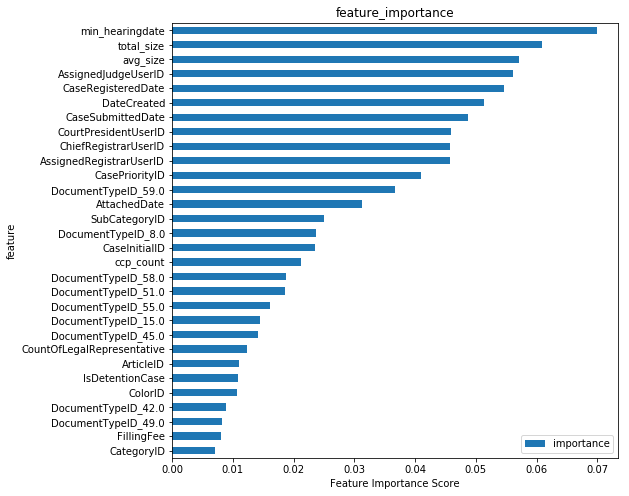

In [17]:
boost.fit(X, Y)
boost.feature_importances_

feat_imp = pd.DataFrame({'importance':boost.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:30]
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title="feature_importance", figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

In [85]:
stregr = StackingRegressor(regressors=[boost], meta_regressor=rf)
# stregr.fit(X,Y)

In [86]:
# y_pred = stregr.predict(X)
# r2_score(Y, y_pred)
np.mean(cross_val_score(stregr, X, Y, scoring='r2', cv=5, verbose=5))

[CV]  ................................................................
[CV] ....................... , score=0.7399893249402107, total=  12.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s remaining:    0.0s


[CV] ....................... , score=0.6930240970955002, total=  12.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.2s remaining:    0.0s


[CV] ....................... , score=0.6650116629251916, total=  13.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.5s remaining:    0.0s


[CV] ....................... , score=0.6850108162196986, total=  12.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   51.2s remaining:    0.0s


[CV] ....................... , score=0.6993123608110139, total=  12.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


0.696469652398323

In [30]:
br = BaggingRegressor(rf)
np.mean(cross_val_score(br, X, Y, scoring='r2', cv=5, verbose=5))
# br.fit(X, Y)
# y_pred = br.predict(X)
# r2_score(Y, y_pred)

[CV]  ................................................................
[CV] ....................... , score=0.6699370299131656, total= 1.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV] ....................... , score=0.6389698485339972, total= 1.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min remaining:    0.0s


[CV] ....................... , score=0.6393246001567718, total= 1.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.6min remaining:    0.0s


[CV] ........................ , score=0.665406693116912, total= 1.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.3min remaining:    0.0s


[CV] ....................... , score=0.6843048233346447, total= 1.6min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.9min finished


0.6595885990110982

In [189]:
ado = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=500, learning_rate=1)

In [190]:
np.mean(cross_val_score(ado, X, Y, scoring='r2', cv=5, verbose=5, n_jobs=-1))
# ado.fit(X, Y)
# y_pred= ado.predict(X)
# r2_score(Y, y_pred)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.4min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished


0.7016846072597269